In [75]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from torch.distributions.multivariate_normal import MultivariateNormal

from sklearn.mixture import GaussianMixture as mix

# our implementation

In [94]:
def gaussian_mixture(x, k, iter=0, cus= None):
  #initialize
  #means = random points
  #covar = unit variance
  #pi = uniform based on k

  perm = torch.randperm(x.size(0))
  idx = perm[:k]
  means = x[idx]
  if cus != None:
    means = cus
  covar = torch.eye(x.size(1), dtype=torch.float).repeat(k,1,1)
  pi = torch.ones(k, dtype=torch.float)/k
  gammas = torch.zeros((x.size(0), k), dtype=torch.float)
  nk = torch.zeros((k), dtype=torch.float)

  for i in range(k):
    gauss = MultivariateNormal(means[i], covar[i])
    gammas[:,i] = pi[i] * torch.exp(gauss.log_prob(x))

  loglike = torch.sum(torch.log(torch.sum(gammas, 1)))

  print(loglike)
  for it in range(iter):
    # E step   
    gammas = gammas / torch.sum(gammas, 1).reshape(-1,1)
    nk = torch.sum(gammas, 0)

    # M step
    for i in range(k):
      means[i] = (1/nk[i]) * torch.sum(x*gammas[:,[i]], 0)
      covar[i] = (1/nk[i]) * (gammas[:,[i]]* (x - means[i])).T @  (x - means[i])
      pi[i] = nk[i] / x.shape[0]

    # eval step
    for i in range(k):
      gauss = MultivariateNormal(means[i], covar[i])
      gammas[:,i] = pi[i] * torch.exp(gauss.log_prob(x))
    loglike = torch.sum(torch.log(torch.sum(gammas, 1)))

    print(loglike)

  gammas = gammas / torch.sum(gammas, 1).reshape(-1,1)
  return means, covar, pi, gammas

# test synthetic data

In [95]:
mean_1 = [3,6]
mean_2 = [2,2]
mean_3 = [6,3]

std_1 = [0.5,2]
std_2 = [0.5,1]
std_3 = [0.5,0.5]

data_points = 200

normal_1 = torch.normal(mean=torch.tensor(mean_1*data_points, dtype=torch.float), std = torch.tensor(std_1*data_points, dtype=torch.float)).reshape(data_points,-1)
normal_2 = torch.normal(mean=torch.tensor(mean_2*data_points, dtype=torch.float), std = torch.tensor(std_2*data_points, dtype=torch.float)).reshape(data_points,-1)
normal_3 = torch.normal(mean=torch.tensor(mean_3*data_points, dtype=torch.float), std = torch.tensor(std_3*data_points, dtype=torch.float)).reshape(data_points,-1)

data = torch.cat([normal_1, normal_2, normal_3])

In [96]:
m, c, p, g = gaussian_mixture(data, 3, iter=10)

In [97]:
print(m)

tensor([[5.9571, 2.9657],
        [2.8898, 5.7375],
        [1.9010, 1.8686]])


# sklearn version on synthetic data

In [76]:
model = mix(n_components = 3)

In [77]:
model.fit(data)

GaussianMixture(n_components=3)

In [98]:
print(model.means_)

[[2.91681792 5.95439688]
 [1.94347823 1.902482  ]
 [5.95715958 2.96573563]]


# import mnist

In [49]:
import torchvision
import torchvision.transforms as transforms
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                            train=True, 
                                       transform=transforms.ToTensor(),  
                                           download=True)

In [50]:
x = torch.empty(0)
y = torch.empty(0)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                            batch_size=1024, 
                                            shuffle=True)
for xs,i in train_loader:
  x = torch.cat([x,xs])
  y = torch.cat([y,i])
  
x_reshape = x.reshape(-1, 28*28)

# sklearn gmm on mnist

In [79]:
model2 = mix(n_components = 10)
model2.fit(x_reshape)

GaussianMixture(n_components=10)

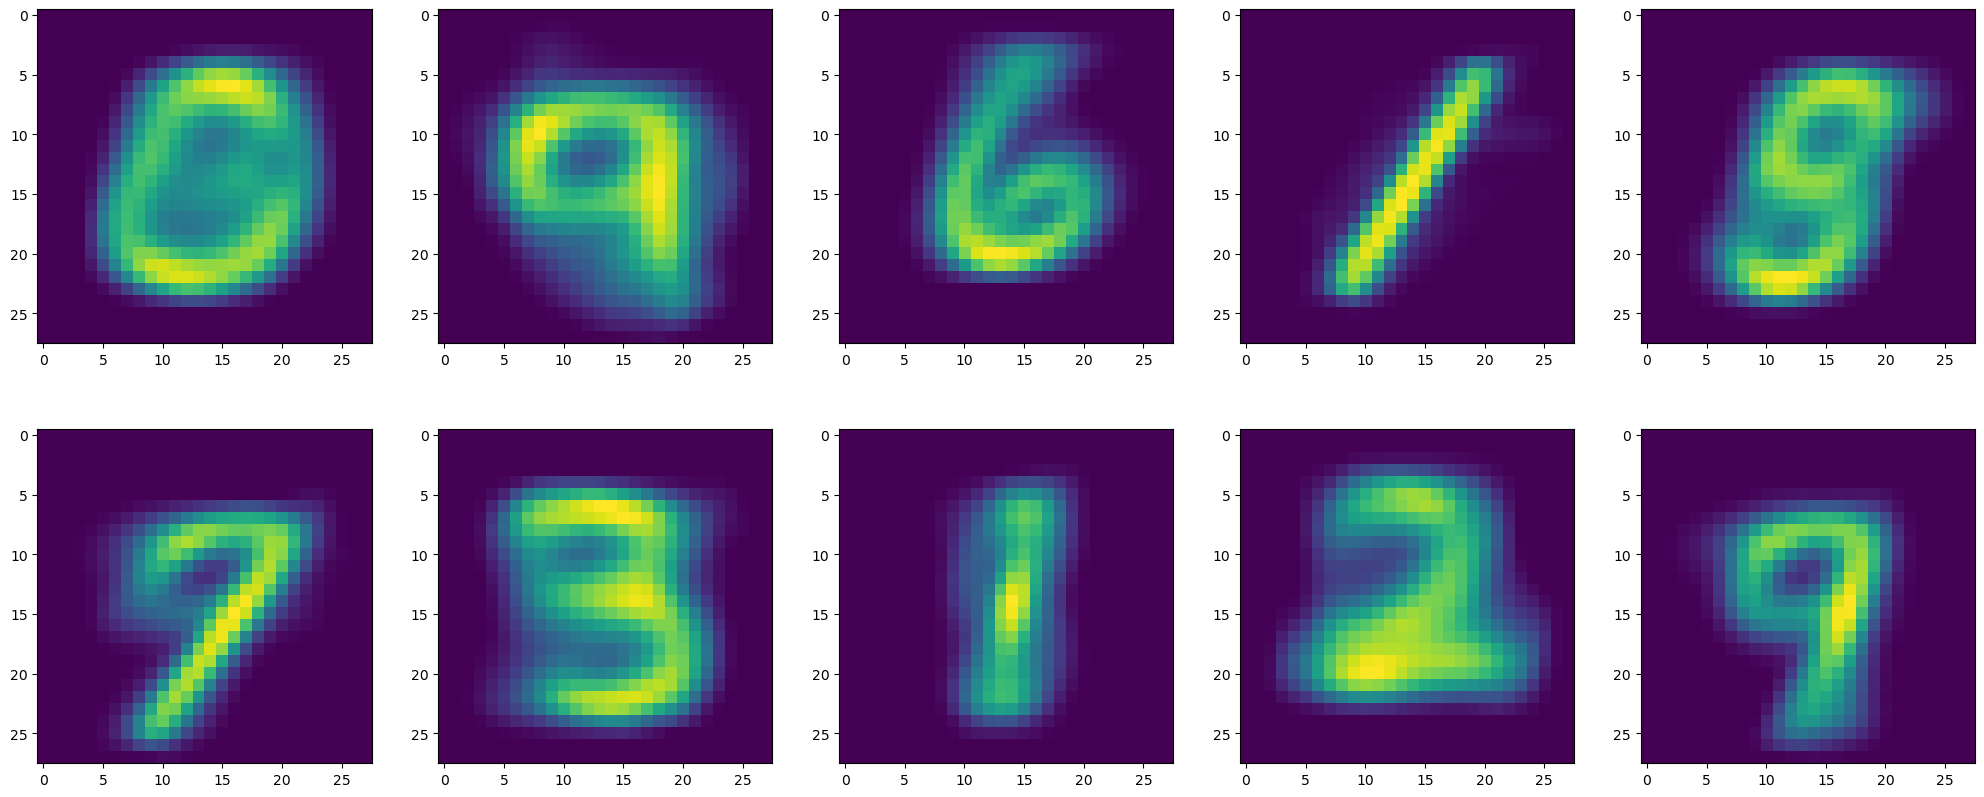

In [99]:
fig, ax = plt.subplots(2,5,figsize=(25,10))

ms = model2.means_
axs = ax.flatten()

for i in range(axs.shape[0]):
    axs[i].imshow(ms[i].reshape(-1, 28))
    
    
fig.savefig('mnists_means.png')